Model: "model_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_14 (InputLayer)       [(None, 100)]             0         
                                                                 
 sequential_26 (Sequential)  (None, 28, 28, 1)         865281    
                                                                 
 sequential_27 (Sequential)  (None, 1)                 212865    
                                                                 
Total params: 1,078,146
Trainable params: 852,609
Non-trainable params: 225,537
_________________________________________________________________
1/1 [==============================] - 0s 114ms/step
epoch:0  d_loss:0.7053  g_loss:0.5480
1/1 [==============================] - 0s 20ms/step
epoch:1  d_loss:0.5065  g_loss:0.2864
1/1 [==============================] - 0s 18ms/step
epoch:2  d_loss:0.4827  g_loss:0.1381
1/1 [==============================] 

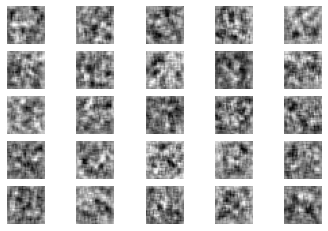

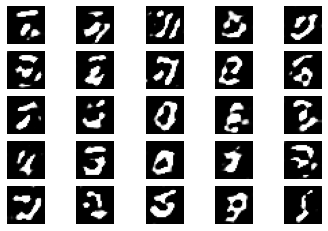

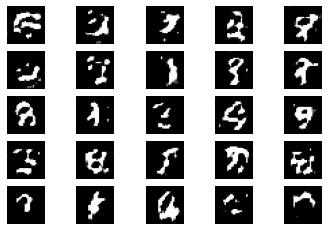

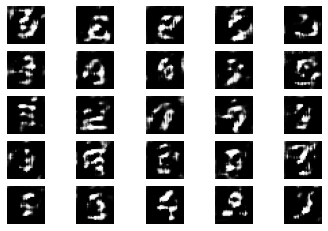

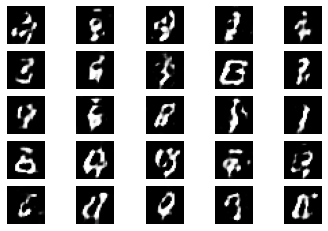

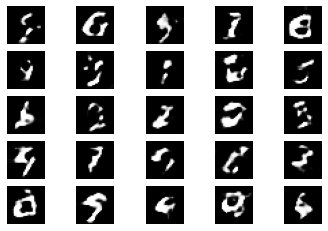

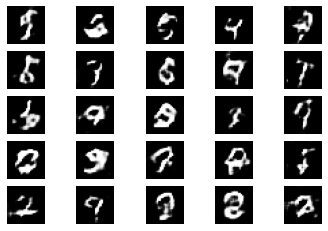

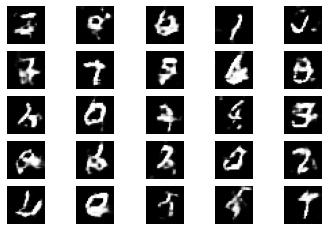

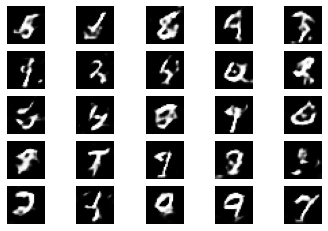

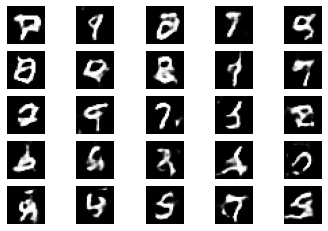

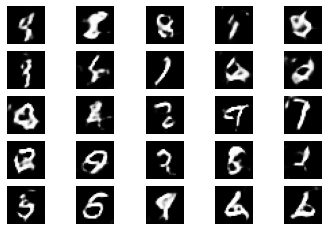

In [14]:
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Input, Dense, Reshape,Flatten, Dropout
from tensorflow.keras.layers import BatchNormalization, Activation, LeakyReLU, UpSampling2D, Conv2D
from tensorflow.keras.models import Sequential, Model

import tensorflow as tf

import numpy as np
import matplotlib.pyplot as plt

# 시드 고정
tf.random.set_seed(2)
np.random.seed(2)

# 생성자 모델
generator = Sequential()
generator.add(Dense(128*7*7, input_dim=100, activation=LeakyReLU(0.2)))
generator.add(BatchNormalization())
generator.add(Reshape((7, 7, 128)))
generator.add(UpSampling2D())
generator.add(Conv2D(64, kernel_size=5, padding='same'))
generator.add(BatchNormalization())
generator.add(Activation(LeakyReLU(0.2)))
generator.add(UpSampling2D())
generator.add(Conv2D(1, kernel_size=5, padding='same', activation='tanh'))

# 판별자 모델
discriminator = Sequential()
discriminator.add(Conv2D(64, kernel_size=5, strides=2, input_shape=(28,28,1), padding="same"))
discriminator.add(Activation(LeakyReLU(0.2)))
discriminator.add(Dropout(0.3))
discriminator.add(Conv2D(128, kernel_size=5, strides=2, padding="same"))
discriminator.add(Activation(LeakyReLU(0.2)))
discriminator.add(Dropout(0.3))
discriminator.add(Flatten())
discriminator.add(Dense(1, activation='sigmoid'))
discriminator.compile(loss='binary_crossentropy', optimizer='adam')
discriminator.trainable = False # 판별자는 학습하지 않음

# 생성자와 판별자 모델을 연결시키는 gan 모델
ginput = Input(shape=(100,))
dis_output = discriminator(generator(ginput))
gan = Model(ginput, dis_output)
gan.compile(loss='binary_crossentropy', optimizer='adam')
gan.summary()

# 신경망을 실행시키는 함수
def gan_train(epoch, batch_size, saving_interval):
    # MNIST 데이터 불러오기
    # 앞서 불러온 MNIST를 다시 이용. 테스트 과정은 필요 없고
    # 이미지만 사용할 것이기 때문에 X_train만 호출
    (X_train, _), (_, _) = mnist.load_data()
    X_train = X_train.reshape(X_train.shape[0], 28, 28, 1).astype('float32')

    # 127.5를 뺀 후 127.5로 나누어서 -1~1 사이의 값으로 변환(픽셀 255)
    X_train = (X_train - 127.5) / 127.5

    true = np.ones((batch_size, 1))
    fake = np.zeros((batch_size, 1))

    for i in range(epoch):
        # 실제 데이터를 판별자에 입력
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        imgs = X_train[idx]
        #print(imgs)
        d_loss_real = discriminator.train_on_batch(imgs, true)

        # 가상 이미지를 판별자에 입력
        noise = np.random.normal(0, 1, (batch_size, 100))
        gen_imgs = generator.predict(noise)
        d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)

        # 판별자와 생성자의 오차를 계산
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
        g_loss = gan.train_on_batch(noise, true)

        print('epoch:%d' % i, ' d_loss:%.4f' % d_loss, ' g_loss:%.4f' % g_loss)

        # 중간 과정을 이미지로 저장하는 부분. 정해진 인터벌만큼 학습되면
        # 그때 만든 이미지를 gan_images 폴더에 저장하라는 의미
        # 소스 코드만 소개
        if i % saving_interval == 0:
          r, c = 5, 5
          noise = np.random.normal(0, 1, (25, 100))
          gen_imgs = generator.predict(noise)

        # Rescale images 0 - 1
          gen_imgs = 0.5 * gen_imgs + 0.5

          fig, axs = plt.subplots(5, 5)
          count = 0
          for j in range(5):
              for k in range(5):
                  axs[j, k].imshow(gen_imgs[count, :, :, 0], cmap='gray')
                  axs[j, k].axis('off')
                  count += 1
          fig.savefig("gan_mnist_%d.png" % i)

# 2022번 반복되고(+1을 하는 것에 주의),
# 배치 크기는 32, 200번마다 결과가 저장
gan_train(2023, 32, 200)
